<a href="https://colab.research.google.com/github/ruheyun/python_pytorch/blob/main/perceptron_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

ruheyun_ganzhiji_path = kagglehub.dataset_download('ruheyun/ganzhiji')

print('Data source import complete.')


In [ ]:
# 安装watermark用于jupyter魔法命令打印环境信息
!pip install watermark
%load_ext watermark
%watermark -a 'yunchao zhao' -v -p torch

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: yunchao zhao

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

torch: 2.5.1+cu124



In [ ]:
# 导入需用的包
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 准备数据集
data = np.genfromtxt('/kaggle/input/ganzhiji/perceptron_toydata.txt', delimiter='\t')
X, y = data[:, :2], data[:, 2]
y = y.astype(np.int32)

# 打印数据大小
print('class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


In [ ]:
# 分为训练集、测试集, 并标准化
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
epsilon = 1e-8
X_train = (X_train - mu) / (sigma + epsilon)
X_test = (X_test - mu) / (sigma + epsilon)

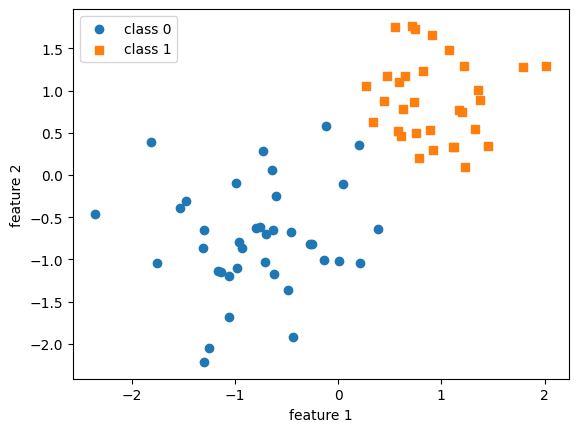

In [ ]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(loc='upper left')
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def custom_where(cond, x_1, x_2):
    return cond * x_1 + (1 - cond) * x_2

class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        predictions = custom_where((linear > 0.).float(), 1, 0)
        return predictions

    def backward(self, x, y):
        predictions = self.forward(x)
        errors = y - predictions
        return errors

    def train(self, x, y, epochs):
        for e in range(epochs):
            for i in range(y.size()[0]):
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)
                self.weights += (errors * x[i]).view(self.num_features, 1)
                self.bias += errors

    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y).float() / y.size()[0]
        return accuracy

In [ ]:
ppn = Perceptron(num_features=2)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('model parameters:')
print(f'weights: {ppn.weights}')
print(f'bias: {ppn.bias}')

model parameters:
weights: tensor([[1.2734],
        [1.3464]])
bias: tensor([-1.])


In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print(f'test set accuracy: {acc * 100: .2f}%')

test set accuracy:  93.33%


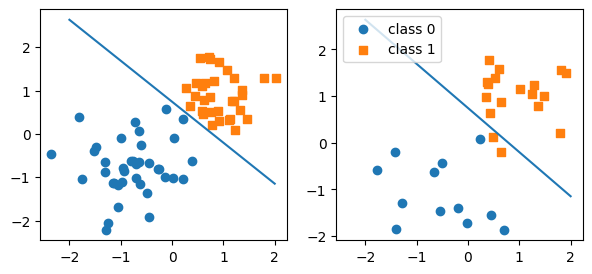

In [ ]:
w, b = ppn.weights, ppn.bias

x_min = -2
y_min = ((-w[0] * x_min) - b[0]) / w[1]

x_max = 2
y_max = ((-w[0] * x_max) - b[0]) / w[1]

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

In [ ]:
%watermark -iv